In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context("talk")
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
N_e = 100
N_i = N_e
N = N_e + N_i
D = 20
sparsity = 0.25
U = 250
T = 100
max_iter = 10
N_weights = int (N * N * sparsity)

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2.5)) for i in list(np.arange(-1,0.5,0.25))]

In [2]:
# colormap = ['tab:green','tab:blue','tab:red','tab:brown']
# fig, axes = plt.subplots(1, figsize=(14,6))
# i = 0
# for distr in ['normal']:
#     K = 10
#     n_sim = 5000
#     norm_A = np.zeros((n_sim))
#     nonnormality_A = np.zeros((n_sim))
#     for sim in range(n_sim):
#         eig = generate_eigenvalues(K=10)
#         A, norm_A[sim], nonnormality_A[sim] = generate_dynamics_A(eigenvalues=eig, normal=False)

#     # axes[0].hist(norm_A, color=colormap[i], label=distr, alpha=0.4, bins=20)
#     axes.hist(nonnormality_A, color=colormap[i], label=distr, alpha=0.4, bins=20)

#     i+= 1
# # axes[0].legend()
# # axes.set_ylim(0,100)
# axes.legend()

In [3]:
K_values = [1,2,3,5,10]#,15,25] 
K = 5
K_vals = [1,2,3,5,10]
color_dict = {1:'tab:purple',2:'tab:pink',3:'tab:cyan',5:'yellowgreen', 15:'olive', 25:'tab:brown'}
color_dict_j = {0:'gold',1:'tab:red',2:'tab:orange'}
j_values = [0,1,2]
j_vals = [0,1,2]
ei_vals=[0,1,2,3]
J_possibility_title = np.array(['J normal - ', 'J normal + co-act - ', 'J uniform - '])
# EI_possibility_title =['- both constraints', '- only self-containment', '- only balance', '- neither']
EI_possibility_title =[r'$\alpha = \beta = 1$', r'$\alpha = 1, \beta = 0$', r'$\alpha = 0, \beta = 1$', r'$\alpha = \beta = 0$']
num_simulations=60

In [4]:
def load_data(N, K_values, j_values, num_simulations, ei=2, parameter='fitW'):
    data_interest = np.empty((len(K_values), len(j_values), num_simulations), dtype=object)
    for k in range(len(K_values)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                data_interest[k, j, simulation] = np.load(f'models/N={N}_K={K_values[k]}/EI={ei}_simulation_{simulation}_J_possibility_{j_values[j]}.npz', allow_pickle=True)[parameter]
    return data_interest



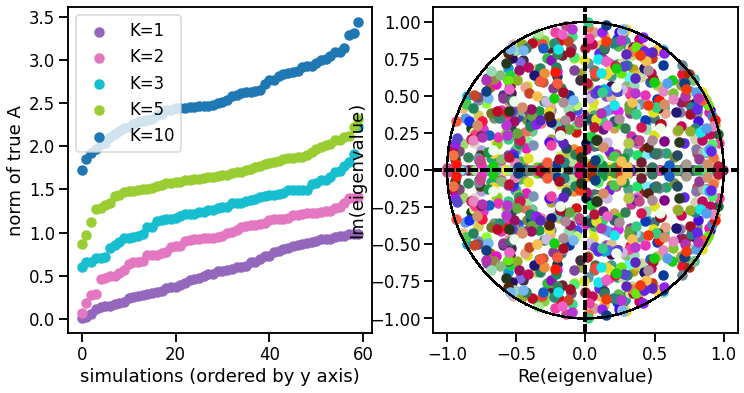

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_norm_eig(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, ei=0, parameter='trueA')
    for k in range(len(K_vals)):
        norm_A = np.zeros((num_simulations))
        for simulation in range(norm_A.shape[0]):
            norm_A[simulation] = np.linalg.norm(trueA[k,0,simulation])
            eigval = np.linalg.eigvals(trueA[k,0,simulation])
            plot_eigenvalues(axes[1], eigval, color=generate_random_color(), label='')
        idx = np.argsort(norm_A)
        axes[0].scatter(range(num_simulations), norm_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('norm of true A')
        axes[0].set_xlabel('simulations (ordered by y axis)')
    axes[0].legend(loc='upper left')

plot_true_A_norm_eig(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

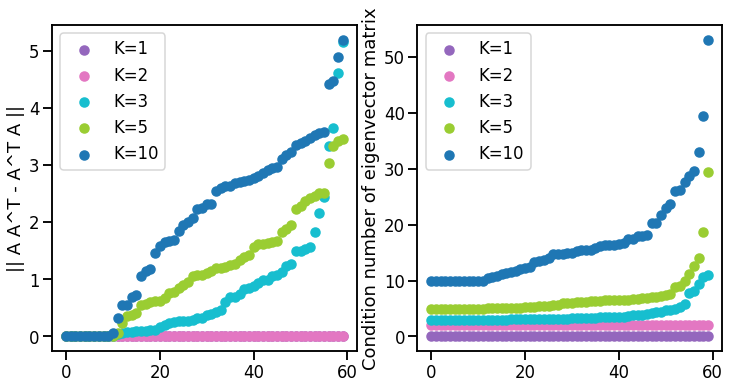

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_non_normality(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, ei=0, parameter='trueA')
    for k in range(len(K_vals)):
        non_normality1_A = np.zeros((num_simulations)) # commutator
        non_normality2_A = np.zeros((num_simulations)) # non orthogonality of eigenvectors via condition number
        for simulation in range(non_normality1_A.shape[0]):
            non_normality1_A[simulation] = np.linalg.norm(trueA[k,0,simulation] @ np.transpose(trueA[k,0,simulation]) - np.transpose(trueA[k,0,simulation]) @ trueA[k,0,simulation]) 
            if K_vals[k] != 1:
                _, eigvec = np.linalg.eig(trueA[k,0,simulation])
                non_normality2_A[simulation] = np.linalg.norm(eigvec) * np.linalg.norm(np.linalg.inv(eigvec))
        idx = np.argsort(non_normality1_A)
        axes[0].scatter(range(num_simulations), non_normality1_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('|| A A^T - A^T A ||')
        idx = np.argsort(non_normality2_A)
        axes[1].scatter(range(num_simulations), non_normality2_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[1].set_ylabel('Condition number of eigenvector matrix')
        axes[0].legend(loc='upper left')
        axes[1].legend(loc='upper left')

plot_true_A_non_normality(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_non_normality', bbox_inches='tight', dpi=300)
    


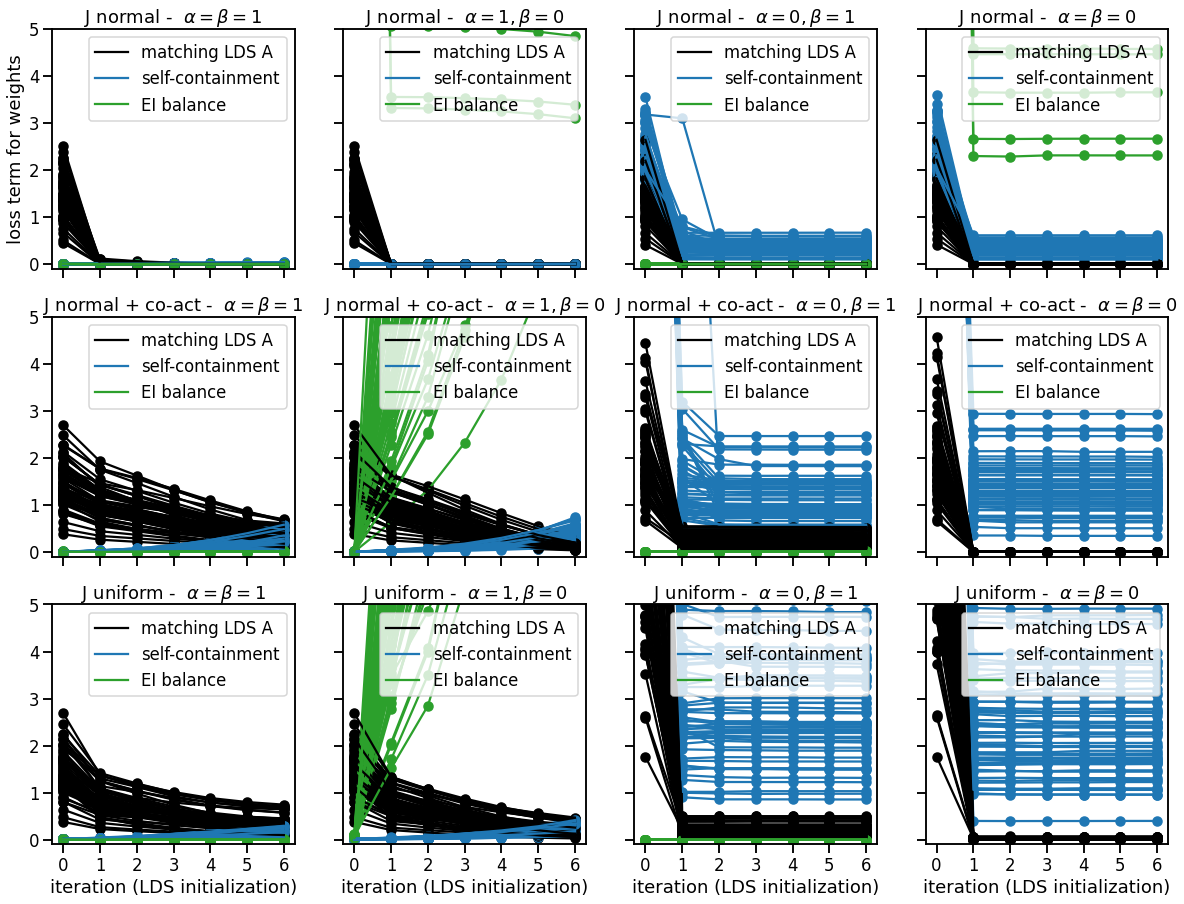

In [7]:
def plot_initialization_loss(axes, num_simulations, K, ei_vals, j_values, zeta_alpha_beta_gamma_list):

    for ei in ei_vals:
        loss_W = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='loss_W')

        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black', label='matching LDS A')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,1], color='tab:blue', label='self-containment')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,2], color='tab:green', label='EI balance')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,2], color='tab:green')
                else:
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,2], color='tab:green')
                    axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,2], color='tab:green')

                axes[-1,ei].set_xlabel('iteration (LDS initialization)')
                axes[j,ei].set_xticks(range(loss_W[0,j,simulation][:,0].shape[0]),range(loss_W[0,j,simulation][:,0].shape[0]))
                axes[j,ei].legend(loc='upper right')
                axes[j,ei].set_title(f'{J_possibility_title[j_values[j]]}' + ' ' + f'{EI_possibility_title[ei]}')

            axes[0,0].set_ylabel('loss term for weights')
            axes[0,0].set_ylim(-0.1,5)
fig, axes = plt.subplots(len(j_vals), len(ei_vals), figsize=(5 * len(ei_vals), 5 * len(j_vals)), sharey=True, sharex= True)
# fig, axes = plt.subplots(len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 5 * len(j_vals)), sharey=True, sharex= True)
plot_initialization_loss(axes, num_simulations, K=K, ei_vals=ei_vals, j_values=j_vals, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
# plt.savefig(f'figures/N={N}_K={K}_figure=1_plot_plot_initialization_loss', bbox_inches='tight', dpi=300)



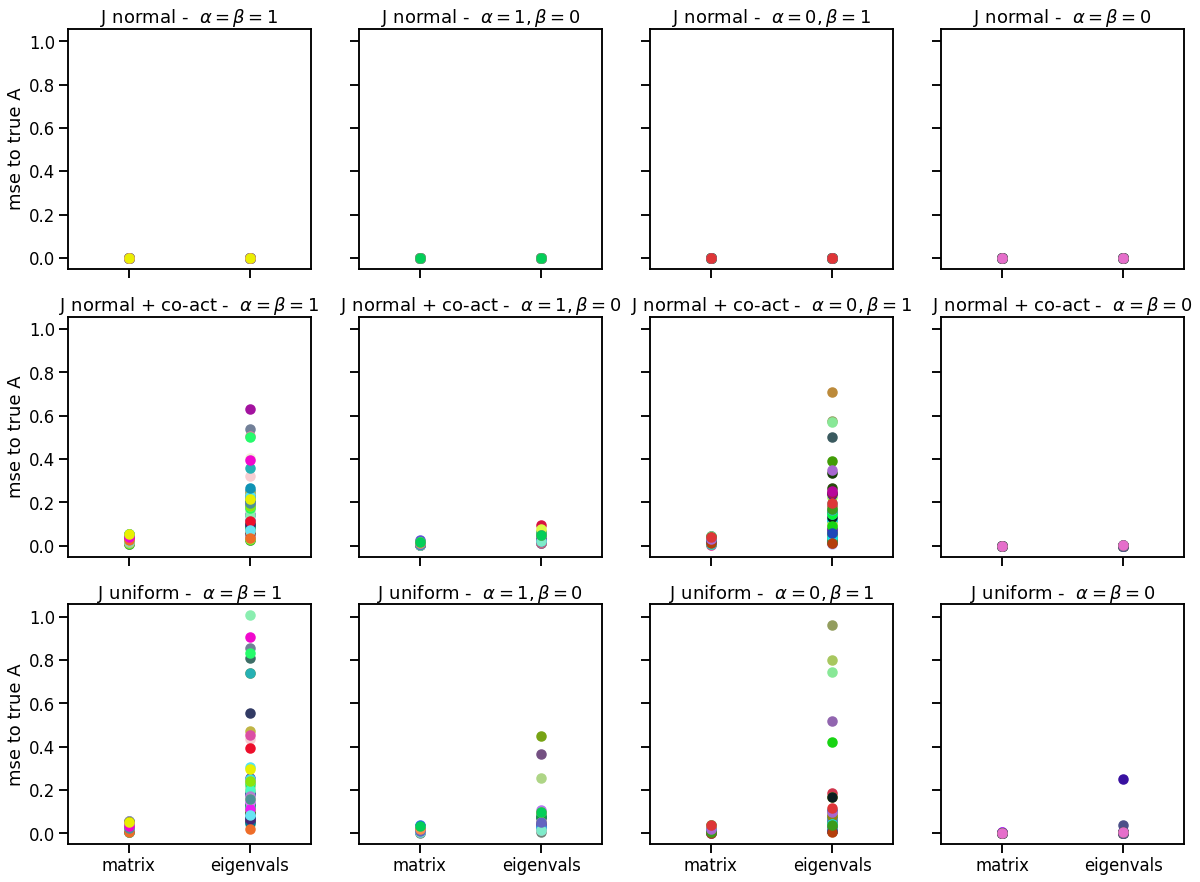

In [8]:
def plot_dynamics_initialization_error(axes, num_simulations, K, ei_vals, j_values=[0,1]):
    # Ensure axes is a 2D array for consistent indexing
    if len(ei_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(ei_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(ei_vals)))

    for ei in range(len(ei_vals)):
        J = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='J')
        trueA = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='trueA')
        initW = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='initW')

        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                initA = build_dynamics_matrix_A(initW[0,j, simulation], J[0,j, simulation])
                axes[j,ei].scatter(0, mse(initA, trueA[0,j, simulation]), color=color)

                eigInit = np.sort(np.linalg.eigvals(initA))
                # print(eigInit)
                eigTrue = np.sort(np.linalg.eigvals(trueA[0,j,simulation]))
                # print(eigTrue)
                eigDiff = np.mean(np.abs(eigInit - eigTrue) ** 2)
                # print(eigDiff)

                # got to order eigenvalues to best match each other and do a different metric
                axes[j,ei].scatter(1, eigDiff, color=color)

                axes[j,ei].set_xticks([0,1], ['matrix','eigenvals'])
                axes[j,ei].set_xlim(-0.5,1.5)
                # axes[j,0].set_xticks(j_values, J_possibility_title[j_values])

                axes[j,ei].set_title(f'{J_possibility_title[j_values[j]]}' + ' ' + f'{EI_possibility_title[ei]}')
                axes[j,0].set_ylabel(f'mse to true A')
fig, axes = plt.subplots(len(j_vals), len(ei_vals), figsize=(5 * len(ei_vals), 5 * len(j_vals)), sharey=True, sharex= True)
plot_dynamics_initialization_error(axes, num_simulations, K, ei_vals=ei_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=2_plot_dynamics_initialization_error', bbox_inches='tight', dpi=300)


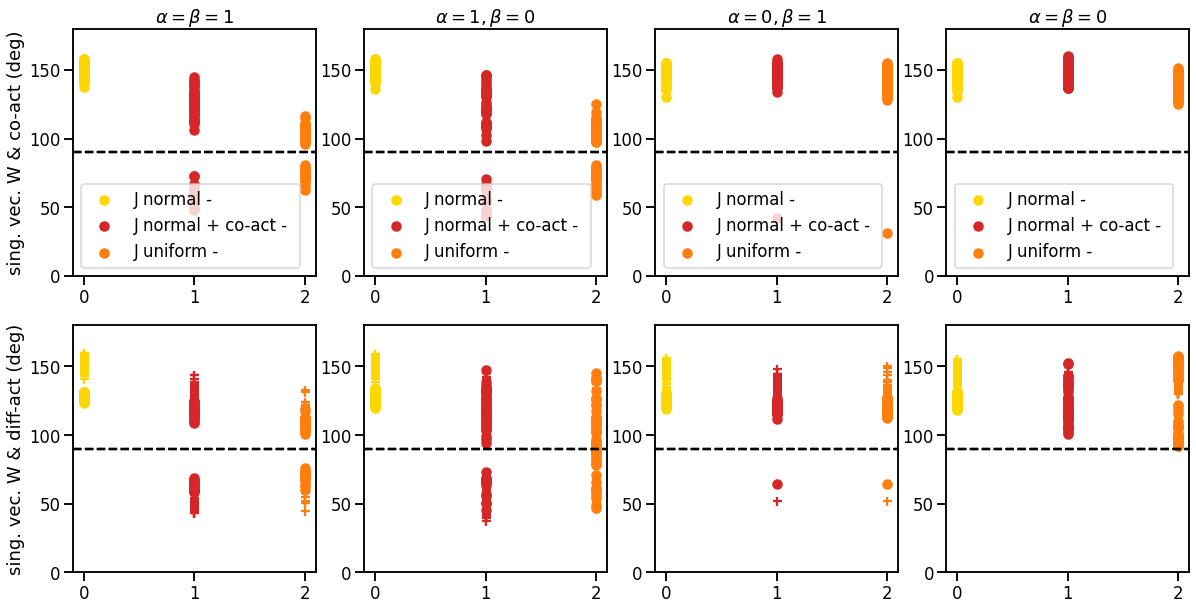

In [9]:
def plot_singular_vectors_W(axes, num_simulations, K, ei_vals, j_values=[0]):
    # Ensure axes is a 2D array for consistent indexing
    if len(ei_vals) == 1:
        axes = axes.reshape((2, len(ei_vals)))  # Single subplot

    co_act = np.ones((N)) * 1/N ** 0.5
    diff_act1 = np.ones((N))
    diff_act1[N_e:] = 0
    diff_act2 = np.ones((N))
    diff_act2[N_e:] = -1

    for j in range(len(j_values)):
        for ei in range(len(ei_vals)):
            initW = load_data(N, K_values=[K], j_values=j_values, ei=ei, num_simulations=num_simulations, parameter='initW')

            for simulation in range(num_simulations):
                U, s, Vh = np.linalg.svd(initW[0,j,simulation])
                if simulation == 0:
                    axes[0,ei].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                    # axes[0,k].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
                    axes[1,ei].scatter(j, angle_vectors(diff_act1, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                    axes[1,ei].scatter(j, angle_vectors(diff_act2, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
                else:
                    axes[0,ei].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]))
                    # axes[0,k].scatter(j, angle_vectors(co_act, U[:,1]), color=color_dict_j.get(j_values[j]), marker='+')
                    axes[1,ei].scatter(j, angle_vectors(diff_act1, Vh[0,:]), color=color_dict_j.get(j_values[j]))
                    axes[1,ei].scatter(j, angle_vectors(diff_act2, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
            # axes[0].scatter(range(num_simulations), norm_W[idx], color=color_dict_j.get(j_values[j]), label=f'j={j_values[j]}')
            axes[0,ei].legend()
            axes[0,0].set_ylabel('sing. vec. W & co-act (deg)')
            axes[1,0].set_ylabel('sing. vec. W & diff-act (deg)')
            axes[0,ei].set_title(f'{EI_possibility_title[ei]}')
            axes[0,ei].axhline(90, color='black',linestyle='dashed')
            axes[1,ei].axhline(90, color='black',linestyle='dashed')
            axes[0,ei].set_ylim(0,180)
            axes[1,ei].set_ylim(0,180)
            # axes[k].set_title(f'Weights init - K = {K_vals[k]}')

fig, axes = plt.subplots(2, len(ei_vals), figsize=(5*len(ei_vals), 10))
plot_singular_vectors_W(axes, num_simulations, K, ei_vals=ei_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

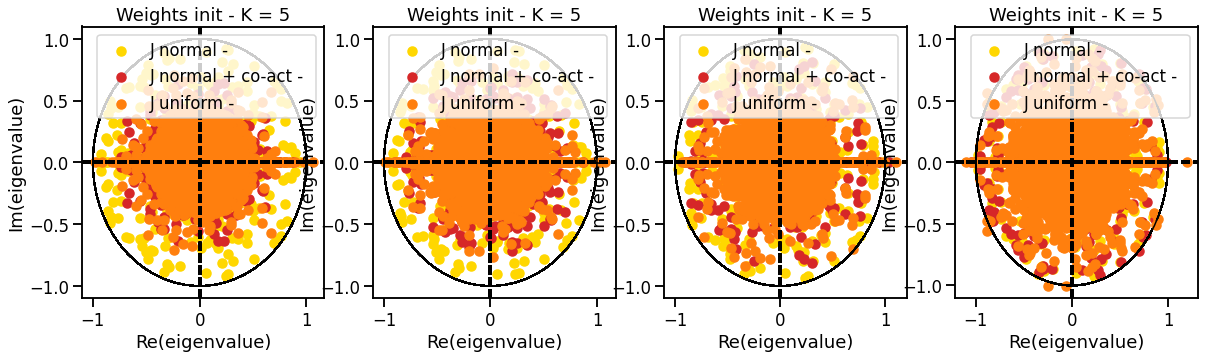

In [10]:
def plot_W_eig(axes, num_simulations, K, ei_vals, j_values=[0]):
    if len(ei_vals) == 1:
        axes = np.array([axes])

    for j in range(len(j_values)):
        for ei in range(len(ei_vals)):
            initW = load_data(N, K_values=[K], j_values=j_values, ei=ei, num_simulations=num_simulations, parameter='initW')
            norm_W = np.zeros((num_simulations))
            for simulation in range(num_simulations):
                norm_W = np.linalg.norm(initW[0,j,simulation])
                eigval = np.linalg.eigvals(initW[0,j,simulation])
                if simulation == 0:
                    plot_eigenvalues(axes[ei], eigval,  color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                else:
                    plot_eigenvalues(axes[ei], eigval,  color=color_dict_j.get(j_values[j]))
            idx = np.argsort(norm_W)
            # axes[0].scatter(range(num_simulations), norm_W[idx], color=color_dict_j.get(j_values[j]), label=f'j={j_values[j]}')
            axes[ei].legend()
            axes[ei].set_title(f'Weights init - K = {K}')

fig, axes = plt.subplots(1, len(ei_vals), figsize=(5*len(ei_vals), 5))
plot_W_eig(axes, num_simulations, K, ei_vals=ei_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

In [11]:
# def plot_unstable_initializations(axes, num_simulations, K_vals, j_values=[0,1]):
#     initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')
#     for k in range(len(K_vals)):
#         binary_unstable_init = np.zeros((len(j_values), num_simulations))
#         count_unstable_init = np.zeros((len(j_values), num_simulations))

#         for simulation in range(num_simulations):
#             for j in range(len(j_values)):
#                 binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(initW[k,j,simulation])
#                 axes[1].scatter(j, count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
#         axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
#         axes[0].set_xticks(j_values, J_possibility_title[j_values])
#         axes[1].set_xticks(j_values, J_possibility_title[j_values])
#         axes[0].set_ylabel('# simulations with any instability in init W')
#         axes[1].set_ylabel('# unstable eigenvalues for init W')
#         axes[0].legend(loc='upper left')

# fig, axes = plt.subplots(1,2, figsize=(12, 5))
# plot_unstable_initializations(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# # plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)




In [12]:
# # whether instability in fitting is solely caused by instability in initialization

In [13]:
# def plot_unstable_fitting(axes, num_simulations, K_vals, j_values=[0,1]):
#     fitW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='fitW')

#     for k in range(len(K_vals)):
#         binary_unstable_init = np.zeros((len(j_values), num_simulations))
#         count_unstable_init = np.zeros((len(j_values), num_simulations))

#         for simulation in range(num_simulations):
#             for j in range(len(j_values)):
                
#                 binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(fitW[k,j,simulation])
#                 axes[1].scatter(j_values[j], count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
#         axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
#         axes[0].set_xticks(j_values, J_possibility_title[j_values])
#         axes[1].set_xticks(j_values, J_possibility_title[j_values])
#         axes[0].set_ylabel('# simulations with any instability in fit W')
#         axes[1].set_ylabel('# unstable eigenvalues for fit W')
#         axes[0].legend(loc='upper left')

# fig, axes = plt.subplots(1,2, figsize=(12, 5))
# plot_unstable_fitting(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# # plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)



# # plt.savefig(f'figures/N={N}_K={K}_figure=4_plot_unstable_fitting', bbox_inches='tight', dpi=300)


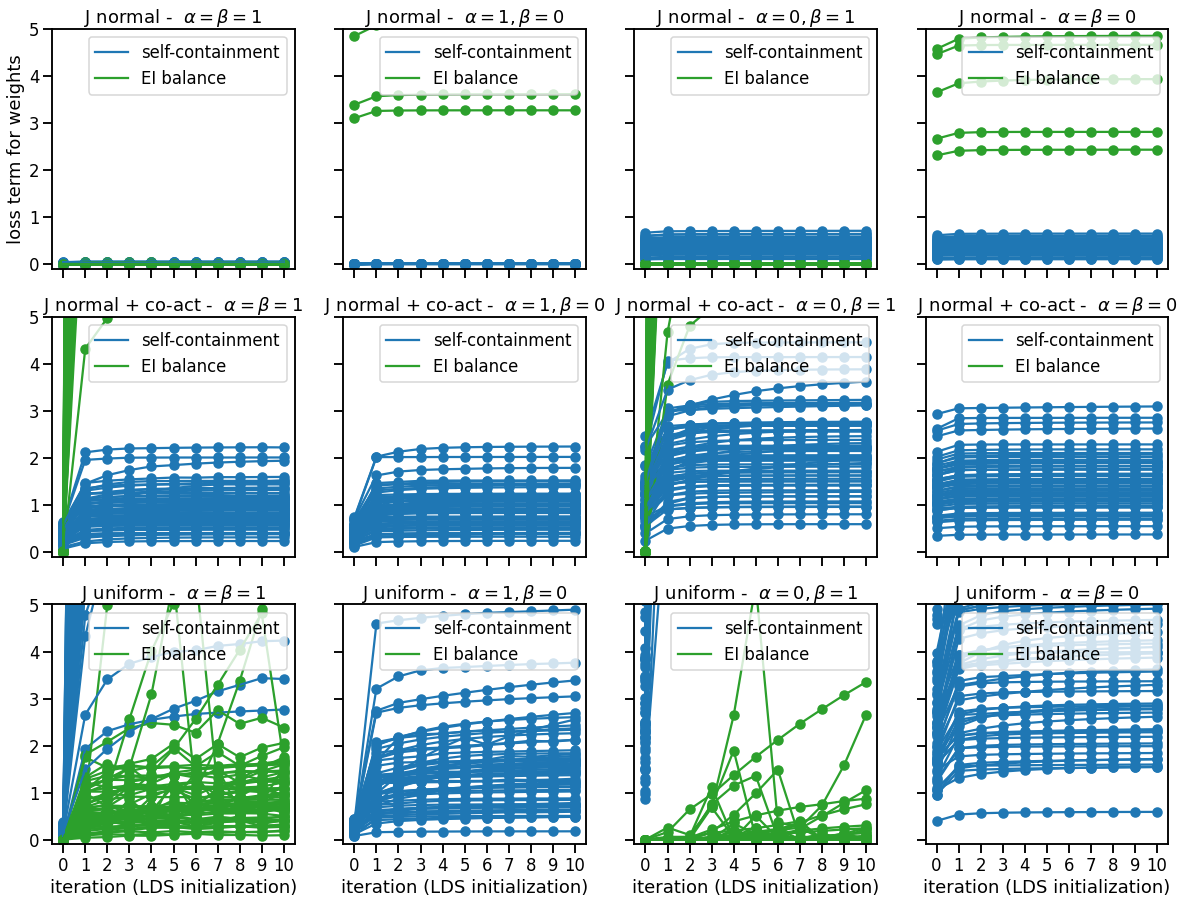

In [14]:
def plot_fitting_loss_constraints(axes, num_simulations, K, ei_vals, j_values, max_iter):
    
    # Ensure axes is a 2D array for consistent indexing
    if len(ei_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(ei_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(K_vals)))

    for ei in ei_vals:
        lossW = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='lossW')

        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    # axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black', label='matching LDS A')
                    # axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    axes[j,ei].plot(range(max_iter+1), lossW[0,j,simulation][:,1], color='tab:blue', label='self-containment')
                    axes[j,ei].scatter(range(max_iter+1), lossW[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].plot(range(max_iter+1), lossW[0,j,simulation][:,2], color='tab:green', label='EI balance')
                    axes[j,ei].scatter(range(max_iter+1), lossW[0,j,simulation][:,2], color='tab:green')
                else:
                    # axes[j,ei].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    # axes[j,ei].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[0,j,simulation][:,0], color='black')
                    axes[j,ei].plot(range(max_iter+1), lossW[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].scatter(range(max_iter+1), lossW[0,j,simulation][:,1], color='tab:blue')
                    axes[j,ei].plot(range(max_iter+1), lossW[0,j,simulation][:,2], color='tab:green')
                    axes[j,ei].scatter(range(max_iter+1), lossW[0,j,simulation][:,2], color='tab:green')

                axes[-1,ei].set_xlabel('iteration (LDS initialization)')
                axes[j,ei].set_xticks(range(lossW[0,j,simulation][:,0].shape[0]),range(lossW[0,j,simulation][:,0].shape[0]))
                axes[j,ei].legend(loc='upper right')
                axes[j,ei].set_title(f'{J_possibility_title[j_values[j]]}' + ' ' + f'{EI_possibility_title[ei]}')

            axes[0,0].set_ylabel('loss term for weights')
            axes[0,0].set_ylim(-0.1,5)
fig, axes = plt.subplots(len(j_vals), len(ei_vals), figsize=(5 * len(ei_vals), 5 * len(j_vals)), sharey=True, sharex= True)
# fig, axes = plt.subplots(len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 5 * len(j_vals)), sharey=True, sharex= True)
plot_fitting_loss_constraints(axes, num_simulations, K=K, ei_vals=ei_vals, j_values=j_vals, max_iter=max_iter)
# plt.savefig(f'figures/N={N}_K={K}_figure=1_plot_plot_initialization_loss', bbox_inches='tight', dpi=300)


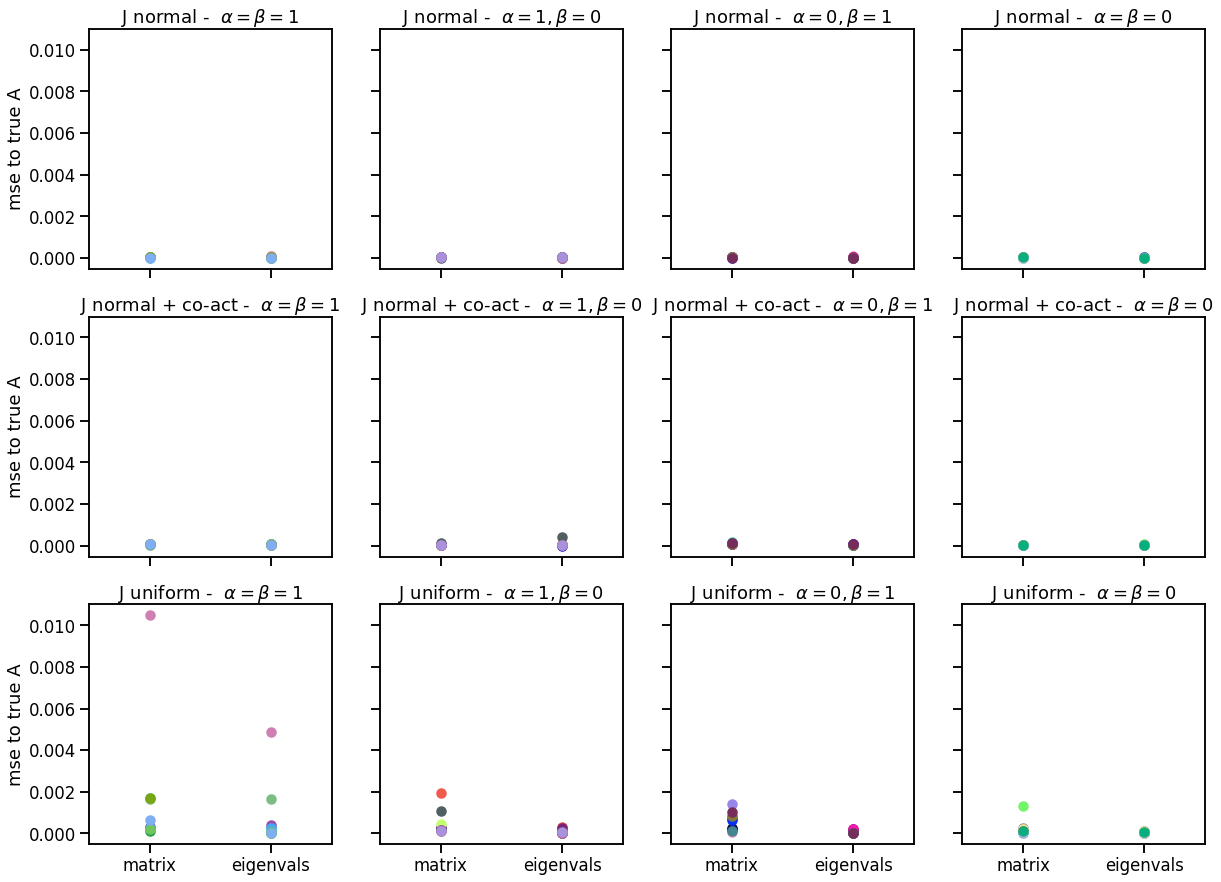

In [15]:
def plot_dynamics_fit_error(axes, num_simulations, K, ei_vals, j_values=[0,1]):
    # Ensure axes is a 2D array for consistent indexing
    if len(ei_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(ei_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(ei_vals)))

    for ei in range(len(ei_vals)):
        J = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='J')
        trueA = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='trueA')
        fitW = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='fitW')

        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                fitA = build_dynamics_matrix_A(fitW[0,j, simulation], J[0,j, simulation])
                axes[j,ei].scatter(0, mse(fitA, trueA[0,j, simulation]), color=color)

                # print(fitA -  trueA[0,j, simulation])
                eigInit = np.sort(np.linalg.eigvals(fitA))
                # print(eigInit)
                eigTrue = np.sort(np.linalg.eigvals(trueA[0,j,simulation]))
                # print(eigTrue)
                eigDiff = np.mean(np.abs(eigInit - eigTrue) ** 2)
                # print(eigDiff)

                # got to order eigenvalues to best match each other and do a different metric
                axes[j,ei].scatter(1, eigDiff, color=color)

                axes[j,ei].set_xticks([0,1], ['matrix','eigenvals'])
                axes[j,ei].set_xlim(-0.5,1.5)
                # axes[j,0].set_xticks(j_values, J_possibility_title[j_values])

                axes[j,ei].set_title(f'{J_possibility_title[j_values[j]]}' + ' ' + f'{EI_possibility_title[ei]}')
                axes[j,0].set_ylabel(f'mse to true A')
fig, axes = plt.subplots(len(j_vals), len(ei_vals), figsize=(5 * len(ei_vals), 5 * len(j_vals)), sharey=True, sharex= True)
plot_dynamics_fit_error(axes, 10, K, ei_vals=ei_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=2_plot_dynamics_initialization_error', bbox_inches='tight', dpi=300)


In [16]:
# def plot_fitting_loss(axes, max_iter, num_simulations, K_vals, j_values):
#     lossW = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='lossW')

#     # Ensure axes is a 2D array for consistent indexing
#     if len(K_vals) == 1:
#         axes = axes.reshape((2 * len(j_values), len(K_vals)))
   
#     for k in range(len(K_vals)):
#         for j in range(len(j_values)):
#             for simulation in range(num_simulations):
#                 if simulation == 0:
#                     axes[2*j,k].plot(range(max_iter+1), lossW[k,j,simulation][:,0], color='black', label='matching LDS A')
#                     # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
#                     axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue', label='self-containment')
#                     # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
#                     axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green', label='EI balance')
#                     # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')
#                 else:
#                     axes[2*j,k].plot(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
#                     # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
#                     axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
#                     # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
#                     axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')
#                     # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')

#                 axes[2*j,k].set_xlabel('iteration')
#                 # axes[k,j].set_xticks(range(lossW[k,j,simulation][:,0].shape[0]),range(lossW[k,j,simulation][:,0].shape[0]))
#                 axes[2*j+1,k].legend(loc='upper right')
#                 axes[2*j,k].set_title(f'J variation {j}')
#                 axes[2*j,k].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])
                

#             axes[0,0].set_ylabel('loss term for weights')
#             # axes[0,0].set_ylim(-0.1,2)
# fig, axes = plt.subplots( 2 * len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 10 * len(j_vals)), sharex= True)
# plot_fitting_loss(axes, max_iter, num_simulations, K_vals=K_vals, j_values=j_vals)
# # plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




In [17]:
# # plot marginal log-likelihood and ECLL terms

# def plot_marginal_log_like(axes, max_iter, num_simulations, K_vals, j_values):
#     ll = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='ll')
#     ecll = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='ll')

#     # Ensure axes is a 2D array for consistent indexing
#     if len(K_vals) == 1 and len(j_values) == 1:
#         axes = np.array([[axes]])  # Single subplot
#     elif len(K_vals) == 1 or len(j_values) == 1:
#         axes = axes.reshape((len(K_vals)), len(j_values))

#     for k in range(len(K_vals)):
#         for j in range(len(j_values)):
#             for simulation in range(num_simulations):
#                 if simulation == 0:
#                     axes[k,j].plot(range(max_iter+1), (ll[k,j,simulation].sum(axis=1)/(U*T))[:], color='tab:red', label='ll')
#                     # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
#                 else:
#                     axes[k,j].plot(range(max_iter+1), (ll[k,j,simulation].sum(axis=1)/(U*T))[:], color='tab:red', label='ll')
#                     # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')

#                 # axes[k,2*j].set_xlabel('weight - LDS initialization')
#                 # # axes[k,j].set_xticks(range(lossW[k,j,simulation][:,0].shape[0]),range(lossW[k,j,simulation][:,0].shape[0]))
#                 # axes[k,2*j+1].legend(loc='upper right')
#                 # axes[k,2*j].set_title(f'J variation {j}')
#                 # axes[k,2*j].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])

#             axes[0,0].set_ylabel('loss term for weights')
#             # axes[0,0].set_ylim(-0.1,2)
# fig, axes = plt.subplots(len(K_vals), len(j_vals), figsize=(5 * len(j_vals), 5 * len(K_vals)), sharex= True)
# plot_marginal_log_like(axes, max_iter, num_simulations, K_vals=K_vals, j_values=j_vals)
# # plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)


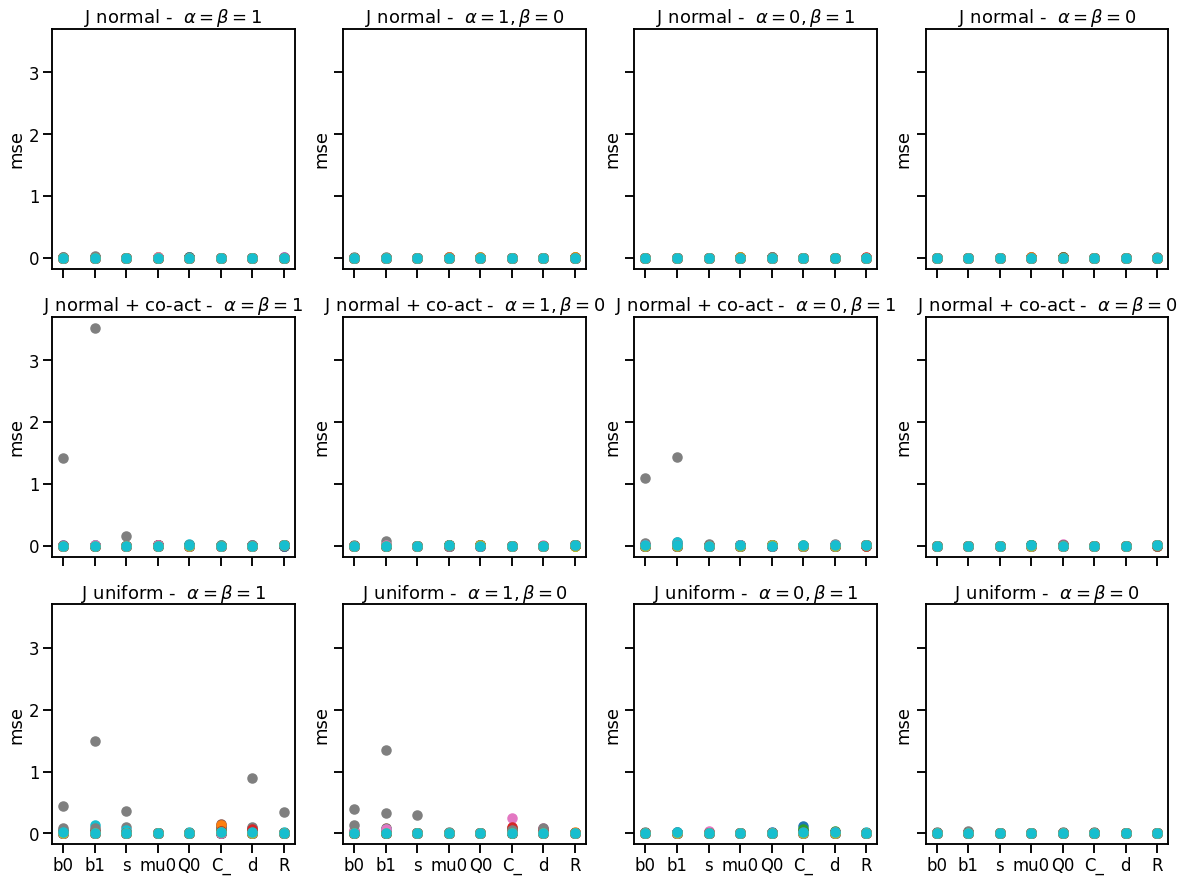

In [18]:
def plot_error_parameters(axes, num_simulations, K, ei_vals, j_values):

    if len(ei_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(ei_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(ei_vals)))
        
    for ei in range(len(ei_vals)):
        b = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='b')
        s = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='s')
        mu0 = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='mu0')
        Q0 = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='Q0')
        C_ = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='C_')
        d = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='d')
        R = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='R')
        true_b = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_b')
        true_s = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_s')
        true_mu0 = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_mu0')
        true_Q0 = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_Q0')
        true_C_ = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_C_')
        true_d = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_d')
        true_R = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='true_R')

        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                # if simulation == 49:
                plot_mse_parameters(axes[j,ei], b[0,j,simulation].item(), s[0,j,simulation], mu0[0,j,simulation], Q0[0,j,simulation], C_[0,j,simulation], d[0,j,simulation], R[0,j,simulation], true_b[0,j,simulation].item(), true_s[0,j,simulation], true_mu0[0,j,simulation], true_Q0[0,j,simulation], true_C_[0,j,simulation], true_d[0,j,simulation], true_R[0,j,simulation])
            axes[j,ei].set_title(f'{J_possibility_title[j_values[j]]}' + ' ' + f'{EI_possibility_title[ei]}')
fig, axes = plt.subplots(len(j_vals),len(ei_vals), figsize=(5 * len(ei_vals),5 * len(j_vals)), sharex= True, sharey=True)
plot_error_parameters(axes, num_simulations, K, ei_vals=ei_vals, j_values=j_vals)

# for eig in range(3):
#     fig, axes = plt.subplots(figsize=(5,5))
#     for simulation in range(30):
#         if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: 
#             plot_mse_parameters(axes, b[eig,simulation].item(), s[eig,simulation], mu0[eig,simulation], Q0[eig,simulation], C_[eig,simulation], d[eig,simulation], R[eig,simulation], true_b[eig,simulation].item(), true_s[eig,simulation], true_mu0[eig,simulation], true_Q0[eig,simulation], true_C_[eig,simulation], true_d[eig,simulation], true_R[eig,simulation])

In [20]:
def generate_random_W(N, N_e, N_i, sparsity, num_simulations, K, ei_vals, j=0):
    
    # fitW = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='fitW')
    J = load_data(N, K_values=[K], j_values=[j], num_simulations=num_simulations, ei=0, parameter='J')
    N = N_e + N_i

    W0 = np.ma.empty((len(ei_vals), num_simulations), dtype=object)
    W1 = np.ma.empty((len(ei_vals), num_simulations), dtype=object)

    for ei in range(len(ei_vals)):
        for simulation in range(num_simulations):
            RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[0,j,simulation], seed=simulation)

            w0 = RNN.generate_stable_weights(R=0.85) 
            W0[ei,simulation] = RNN.build_full_weight_matrix(w0)
            JpJ = np.linalg.pinv(RNN.J) @ RNN.J
            for iter in range(10):
                if ei in [0,1]: # alpha
                    # to satisfy low-dim dynamics constraint
                    W0[ei,simulation] = JpJ @ W0[ei,simulation] @ JpJ + (np.eye(RNN.N) - JpJ) @ W0[ei,simulation] @ (np.eye(RNN.N) - JpJ)

                if ei in [0,2]: # beta
                    # to satisfy E-I balance 
                    W0[ei,simulation] = W0[ei,simulation] - W0[ei,simulation] @ np.ones((RNN.N,1)) @ np.ones((1, RNN.N)) / RNN.N
                # to keep only active weights & Dale's law
                w0 = np.abs(RNN.get_nonzero_weight_vector(W0[ei,simulation]))
                W0[ei,simulation] = RNN.build_full_weight_matrix(w0)
            
            # generating random W in second way
            # RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[0,j,simulation], seed=1)
            w1 = np.random.uniform(0, 1, RNN.N_weights).reshape(((RNN.N_weights, 1)))
            w1 = w1 / np.sqrt(N)
            W1[ei,simulation] = RNN.build_full_weight_matrix(w1)
            for iter in range(10):
                if ei in [0,1]: # alpha
                    # to satisfy low-dim dynamics constraint
                    W1[ei,simulation] = JpJ @ W1[ei,simulation] @ JpJ + (np.eye(RNN.N) - JpJ) @ W1[ei,simulation] @ (np.eye(RNN.N) - JpJ)

                if ei in [0,2]: # beta
                    # to satisfy E-I balance 
                    W1[ei,simulation] = W1[ei,simulation] - W1[ei,simulation] @ np.ones((RNN.N,1)) @ np.ones((1, RNN.N)) / RNN.N
                # to keep only active weights & Dale's law
                w1 = np.abs(RNN.get_nonzero_weight_vector(W1[ei,simulation]))
                W1[ei,simulation] = RNN.build_full_weight_matrix(w1)
            
    return W0, W1

W0, W1 = generate_random_W(N, N_e, N_i, sparsity, num_simulations=30, K=K, ei_vals=[0,1,2,3], j=0)
            

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

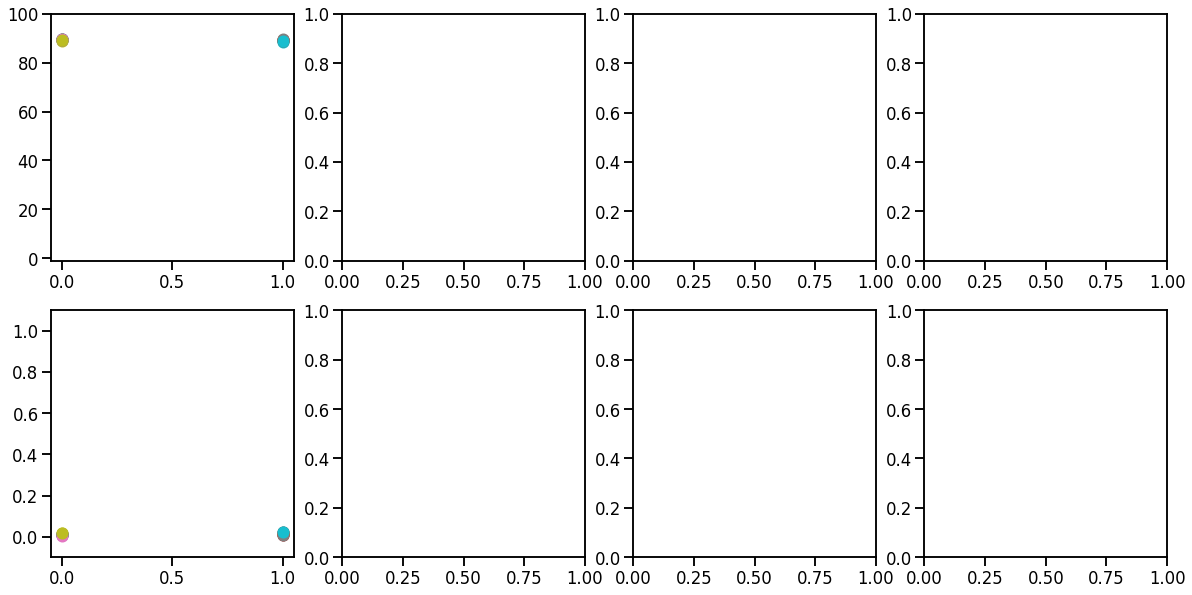

In [127]:
ei_vals = [0,1,2,3]
j = 0

fig, axes = plt.subplots(2, len(ei_vals), figsize=(5 * len(ei_vals), 10))
J = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=0, parameter='J')
for ei in range(len(ei_vals)):
    for simulation in range(10):#range(num_simulations):

        U, s, Vh = np.linalg.svd(W0[ei,simulation])
        v_proj, angle = projection_on_subspace(U[:,0],J[0,j,simulation])
        axes[0,ei].scatter(0, angle, linewidth=3)
        axes[1,ei].scatter(0, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), linewidth=3)

        U, s, Vh = np.linalg.svd(W1[ei,simulation])
        v_proj, angle = projection_on_subspace(U[:,0],J[0,j,simulation])
        axes[0,ei].scatter(1, angle, linewidth=3)
        axes[1,ei].scatter(1, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), linewidth=3)

        axes[0,ei].set_ylim(-1,100)
        axes[1,ei].set_ylim(-0.1,1.1)



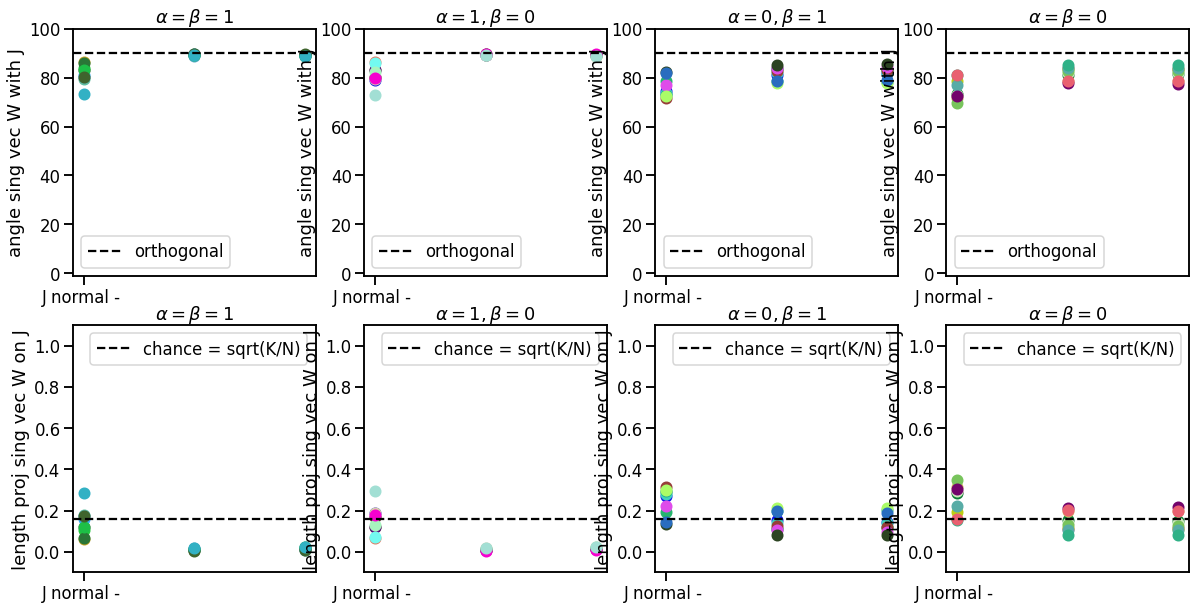

In [21]:
def plot_relationship_W_J(axes, num_simulations, K, ei_vals, j_values=[0], W0=W0, W1=W1):
    
    if len(ei_vals) == 1:
        axes = axes.reshape((2, len(ei_vals)))

    for ei in range(len(ei_vals)):
        fitW = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='fitW')
        J = load_data(N, K_values=[K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='J')

        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                # ones = np.ones((J[0,0].shape[1]))
                # v_proj, angle = projection_on_subspace(ones, J[j,simulation])
                # axes[0].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)
                
                U, s, Vh = np.linalg.svd(fitW[0,j,simulation])
                v_proj, angle = projection_on_subspace(U[:,0],J[0,j,simulation])
                axes[0,ei].scatter(j_values[j], angle, color=color, linewidth=3)
                axes[1,ei].scatter(j_values[j], np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)

                U, s, Vh = np.linalg.svd(W0[ei,simulation])
                v_proj, angle = projection_on_subspace(U[:,0],J[0,j,simulation])
                axes[0,ei].scatter(j_values[j]+1, angle, color=color, linewidth=3)
                axes[1,ei].scatter(j_values[j]+1, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)

                U, s, Vh = np.linalg.svd(W1[ei,simulation])
                v_proj, angle = projection_on_subspace(U[:,0],J[0,j,simulation])
                axes[0,ei].scatter(j_values[j]+2, angle, color=color, linewidth=3)
                axes[1,ei].scatter(j_values[j]+2, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)


        axes[0,ei].axhline(90, color='black', linestyle='dashed', label='orthogonal')
        axes[1,ei].axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')

        axes[0,ei].set_xticks(j_values, J_possibility_title[j_values])
        axes[1,ei].set_xticks(j_values, J_possibility_title[j_values])
        axes[0,ei].set_ylabel('angle sing vec W with J')
        axes[0,ei].set_ylim(-1,100)
        axes[1,ei].set_ylim(-0.1,1.1)
        axes[1,ei].set_ylabel('length proj sing vec W on J')
        axes[0,ei].legend()
        axes[1,ei].legend()
        axes[0,ei].set_title(f'{EI_possibility_title[ei]}')
        axes[1,ei].set_title(f'{EI_possibility_title[ei]}')

fig, axes = plt.subplots(2, len(ei_vals), figsize=(5 * len(ei_vals), 10))
plot_relationship_W_J(axes, num_simulations=10, K=K, ei_vals=ei_vals, j_values=[0])
# plt.savefig(f'figures/N={N}_K={K}_figure=7_plot_relationship_W_J', bbox_inches='tight', dpi=300)


# fig, axes = plt.subplots(figsize=(5,6))
# for k in range(K):
#     v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
#     axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

# v_proj, angle = projection_on_subspace(ones, J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

# v_proj, angle = projection_on_subspace(U[:,0],J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


# axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
# axes.set_ylabel('length of projection on subspace J')
# # axes.set_ylim(0,120)
# axes.set_xticks([],[])
# # axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
# axes.legend()

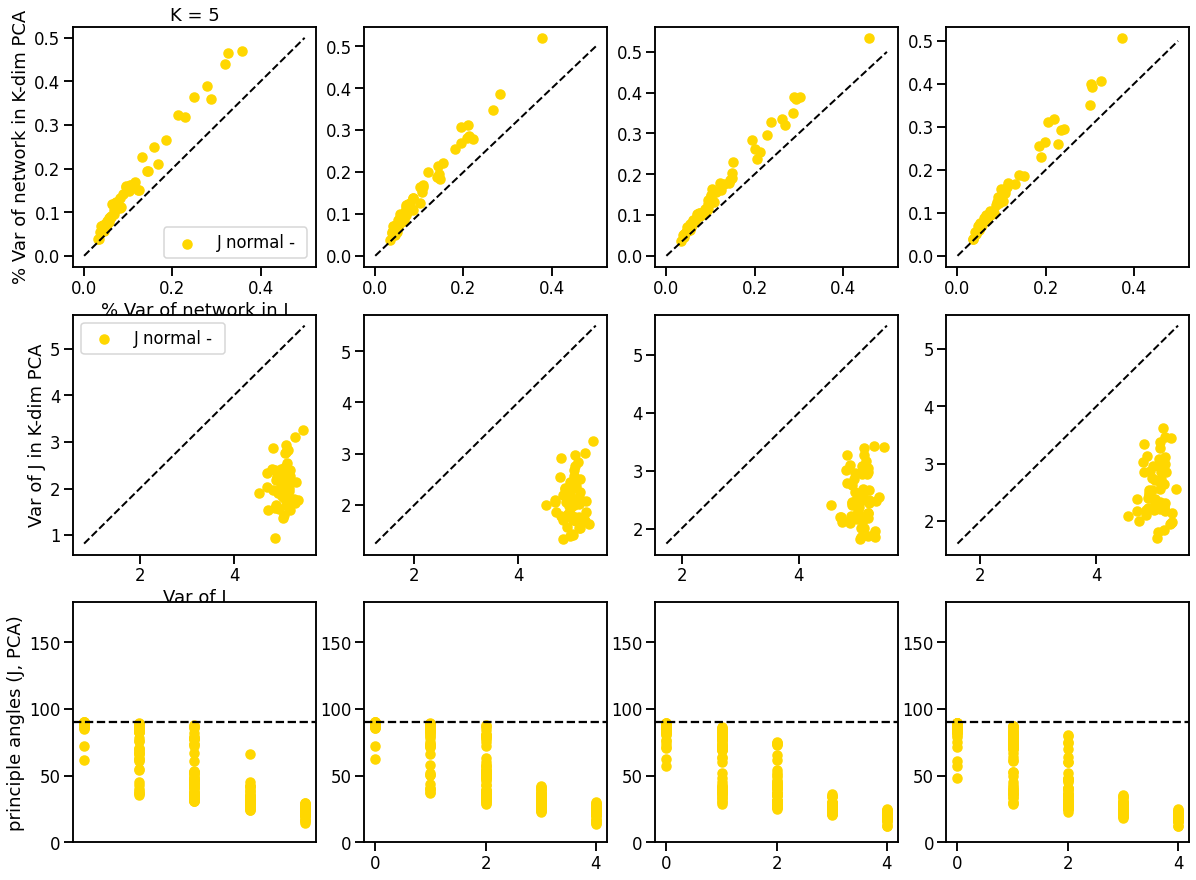

In [27]:
def PCA_misalignment_J(axes, num_simulations, K, ei_vals, j, W0, W1):
    
    if len(ei_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(ei_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(ei_vals)))

    for ei in range(len(ei_vals)):
        v = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='v')
        J = load_data(N, [K], j_values=j_values, num_simulations=num_simulations, ei=ei, parameter='J')

        for simulation in range(num_simulations):
                
            if v[0,j,simulation].shape[0] == 1:
                continue
            # PCA on network activity
            v_concat = v[0,j,simulation].reshape(v[0,j,simulation].shape[0] * v[0,j,simulation].shape[1], v[0,j,simulation].shape[2])
            mean = v_concat.mean(axis=0)

            #   mean-center
            v_concat = v_concat - mean

            eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
            idx = np.argsort(eigval_PCA)[::-1]
            eigval_PCA = eigval_PCA[idx]
            eigvec_PCA = eigvec_PCA[:,idx]

            fraction_cov_var_J, fraction_cov_var_PCA, cov_var_J_PCA = covariance_alignment(v_concat, J[0,j,simulation], eigvec_PCA[:,:K])
            if simulation == 0 :
                axes[0,ei].scatter(fraction_cov_var_J, fraction_cov_var_PCA, color=color_dict_j.get(j_vals[j]), label=f'{J_possibility_title[j_vals[j]]}')
                axes[1,ei].scatter(np.trace(J[0,j,simulation] @ J[0,j,simulation].T), cov_var_J_PCA, color=color_dict_j.get(j_vals[j]), label=f'{J_possibility_title[j_vals[j]]}')
            else:
                axes[0,ei].scatter(fraction_cov_var_J, fraction_cov_var_PCA, color=color_dict_j.get(j_vals[j]))
                axes[1,ei].scatter(np.trace(J[0,j,simulation].T @ J[0,j,simulation]), cov_var_J_PCA, color=color_dict_j.get(j_vals[j]))
            axes[2,ei].scatter(range(K), np.rad2deg(scipy.linalg.subspace_angles(J[0,j,simulation].T, eigvec_PCA[:,:K])), color=color_dict_j.get(j_vals[j]))
        axes[0,0].set_xlabel('% Var of network in J')
        axes[0,0].set_ylabel('% Var of network in K-dim PCA')
        axes[0,0].set_title(f'K = {K}')
        axes[0,0].legend()
        axes[1,0].legend()
        axes[1,0].set_xlabel('Var of J')
        axes[1,0].set_ylabel('Var of J in K-dim PCA')
        axes[2,ei].set_ylim(0,180)
        axes[2,0].set_xticks([],[])
        axes[2,ei].axhline(90, linestyle='dashed',color='black')
        axes[2,0].set_ylabel('principle angles (J, PCA)')
        x = np.linspace(0, 0.5, 100)
        y = x  # Diagonal y = x

        # Plot with dashed linestyle
        axes[0,ei].plot(x, y, linestyle='--', color='black', linewidth=2)

        # Get current axis limits
        x_min, x_max = axes[1,ei].get_xlim()
        y_min, y_max = axes[1,ei].get_ylim()

        # Ensure the line spans the plot fully
        start = min(x_min, y_min)
        end = max(x_max, y_max)

        # Plot the diagonal line
        axes[1,ei].plot([start, end], [start, end], linestyle='--', color='black', linewidth=2)

fig, axes = plt.subplots(3, len(ei_vals), figsize=(5 * len(ei_vals),5 * 3))
PCA_misalignment_J(axes, num_simulations=60, K=K, ei_vals=ei_vals, j=0, W0=W0, W1=W1)
